# Description

- Initialize with returns, predictions, target volatility, and oos start date
- Evaluate portfolios generated from the predictions

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import core.config as cconfig
import core.dataflow_model.model_evaluator as modeval
import core.dataflow_model.model_plotter as modplot
import core.dataflow_model.utils as cdmu
import helpers.dbg as dbg
import helpers.printing as hprint

In [2]:
dbg.init_logger(verbosity=logging.INFO)
#dbg.init_logger(verbosity=logging.DEBUG)

_LOG = logging.getLogger(__name__)

# _LOG.info("%s", env.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-e7715308-84ba-4edd-b1e4-1aeda980ba61.json'


# Notebook config

In [3]:
#exp_dir = "s3://eglp-spm-sasm/experiments/experiment.RH2Ef.v1_9-all.5T.20210831-004747.run1.tgz"
exp_dir = "./experiment.RH2Ef.v1_9-all.5T.20210831-004747.run1.tgz"# exp_dir = "s3://alphamatic-data/experiments/..."

eval_config = cconfig.get_config_from_nested_dict(
    {
        "exp_dir": exp_dir,
        "model_evaluator_kwargs": {
            "returns_col": "vwap_ret_0_vol_adj_clipped_2",
            "predictions_col": "vwap_ret_0_vol_adj_clipped_2",
            #"oos_start": "2017-01-01",
        },
        "bh_adj_threshold": 0.1,
        "resample_rule": "W",
        "mode": "ins",
        "target_volatility": 0.1,
    }
)

# Initialize ModelEvaluator and ModelPlotter

<AxesSubplot:xlabel='x'>

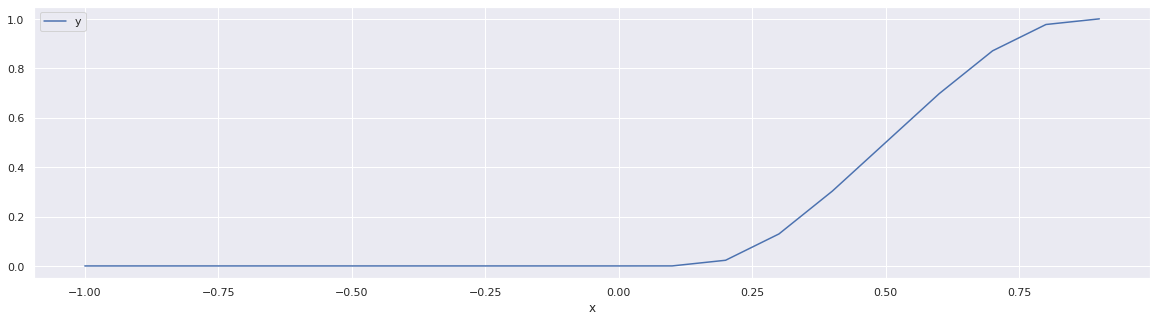

In [23]:
import pandas as pd
import core.signal_processing as csigna

xs = [x / 10 for x in range(-10, 10)]
#y = [csigna.c_infinity(x) for x in xs]
y = [csigna.c_infinity_step_function(x) for x in xs]
#y = [csigna.c_infinity_bump_function(x, 2, 10) for x in xs]

df = pd.DataFrame()
df["x"] = pd.Series(xs)
df["y"] = pd.Series(y)

df.plot("x")

In [5]:
# Load the data.
selected_idxs = list(range(2))
result_bundles = cdmu.yield_experiment_artifacts(
    eval_config["exp_dir"],
    "result_bundle.pkl",
    selected_idxs=selected_idxs,
)

In [6]:
# Build the ModelEvaluator.
evaluator = modeval.build_model_evaluator_from_result_bundles(
    result_bundles,
    abort_on_error=False,
    **eval_config["model_evaluator_kwargs"].to_dict(),
)
# Build the ModelPlotter.
plotter = modplot.ModelPlotter(evaluator)

# Load artifacts 'result_bundle.pkl' from './experiment.RH2Ef.v1_9-all.5T.20210831-004747.run1.tgz'
While expanding './experiment.RH2Ef.v1_9-all.5T.20210831-004747.run1.tgz' dst dir './experiment.RH2Ef.v1_9-all.5T.run1/' already exists: skipping
Found 534 experiment subdirs in './experiment.RH2Ef.v1_9-all.5T.run1/'


Loading artifacts:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
evaluator._data

{0:                            vwap_ret_0_vol_adj_clipped_2  vwap_ret_0_vol_adj_clipped_2
 end_time                                                                             
 2009-01-02 09:05:00-05:00                           NaN                           NaN
 2009-01-02 09:10:00-05:00                           NaN                           NaN
 2009-01-02 09:15:00-05:00                           NaN                           NaN
 2009-01-02 09:20:00-05:00                           NaN                           NaN
 2009-01-02 09:25:00-05:00                           NaN                           NaN
 ...                                                 ...                           ...
 2017-01-04 16:40:00-05:00                           NaN                           NaN
 2017-01-04 16:45:00-05:00                           NaN                           NaN
 2017-01-04 16:50:00-05:00                           NaN                           NaN
 2017-01-04 16:55:00-05:00              

# Analysis

In [ ]:
pnl_stats = evaluator.calculate_stats(
    mode=eval_config["mode"], target_volatility=eval_config["target_volatility"]
)
display(pnl_stats)

## Model selection

In [ ]:
plotter.plot_multiple_tests_adjustment(
    threshold=eval_config["bh_adj_threshold"], mode=eval_config["mode"]
)

In [ ]:
# TODO(gp): Move this chunk of code in a function.
col_mask = (
    pnl_stats.loc["signal_quality"].loc["sr.adj_pval"]
    < eval_config["bh_adj_threshold"]
)
selected = pnl_stats.loc[:, col_mask].columns.to_list()
not_selected = pnl_stats.loc[:, ~col_mask].columns.to_list()

print("num model selected=%s" % hprint.perc(len(selected), pnl_stats.shape[1]))
print("model selected=%s" % selected)
print("model not selected=%s" % not_selected)

# Use `selected = None` to show all the models.

In [ ]:
plotter.plot_multiple_pnls(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

## Return correlation

In [ ]:
plotter.plot_correlation_matrix(
    series="returns",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

In [ ]:
plotter.plot_effective_correlation_rank(
    series="returns",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

## Model correlation

In [ ]:
plotter.plot_correlation_matrix(
    series="pnl",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

In [ ]:
plotter.plot_effective_correlation_rank(
    series="pnl",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

## Aggregate model

In [ ]:
pnl_srs, pos_srs, aggregate_stats = evaluator.aggregate_models(
    keys=selected,
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)
display(aggregate_stats)

In [ ]:
plotter.plot_sharpe_ratio_panel(keys=selected, mode=eval_config["mode"])

In [ ]:
plotter.plot_rets_signal_analysis(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

In [ ]:
plotter.plot_performance(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

In [ ]:
plotter.plot_rets_and_vol(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

In [ ]:
assert 0

In [ ]:
plotter.plot_positions(
    keys=selected,
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

In [ ]:
# Plot the returns and prediction for one or more models.
model_key = selected[:1]
plotter.plot_returns_and_predictions(
    keys=model_key,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)